In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr


## 1. Data Preparation & Compositional Setup


In [7]:
# Load occupancy data
occupancy = pd.read_excel("../data/housing/occupancy_rating_bedrooms_wards.xlsx", sheet_name="2021")

# Filter out City of London
occupancy = occupancy[occupancy['local authority code'] != 'E09000001']

# Calculate occupancy rate percentages for each ward
occupancy['total_households'] = occupancy['All Households']
total_households = occupancy['All Households']
occupancy['pct_plus2_more'] = occupancy['Occupancy rating: +2 or more'] / total_households * 100
occupancy['pct_plus1'] = occupancy['+1'] / total_households * 100
occupancy['pct_zero'] = occupancy['0'] / total_households * 100
occupancy['pct_minus1'] = occupancy['-1'] / total_households * 100
occupancy['pct_minus2_less'] = occupancy['-2 or less'] / total_households * 100

# Rename columns for clarity
occupancy = occupancy.rename(columns={'ward code': 'Ward Code'})

# Load burglary data
burglary = pd.read_csv("../data/burglary.csv")
burglary = burglary[burglary['Year'] == 2021]

burglary_df = burglary.groupby('Ward Code').size().reset_index(name='burglary_count')
total = burglary_df['burglary_count'].sum()
burglary_df['burglary_pct'] = (burglary_df['burglary_count'] / total) * 100

merged_data = pd.merge(occupancy, burglary_df, on='Ward Code', how='inner')


 ## 2. Exploratory Data Analysis


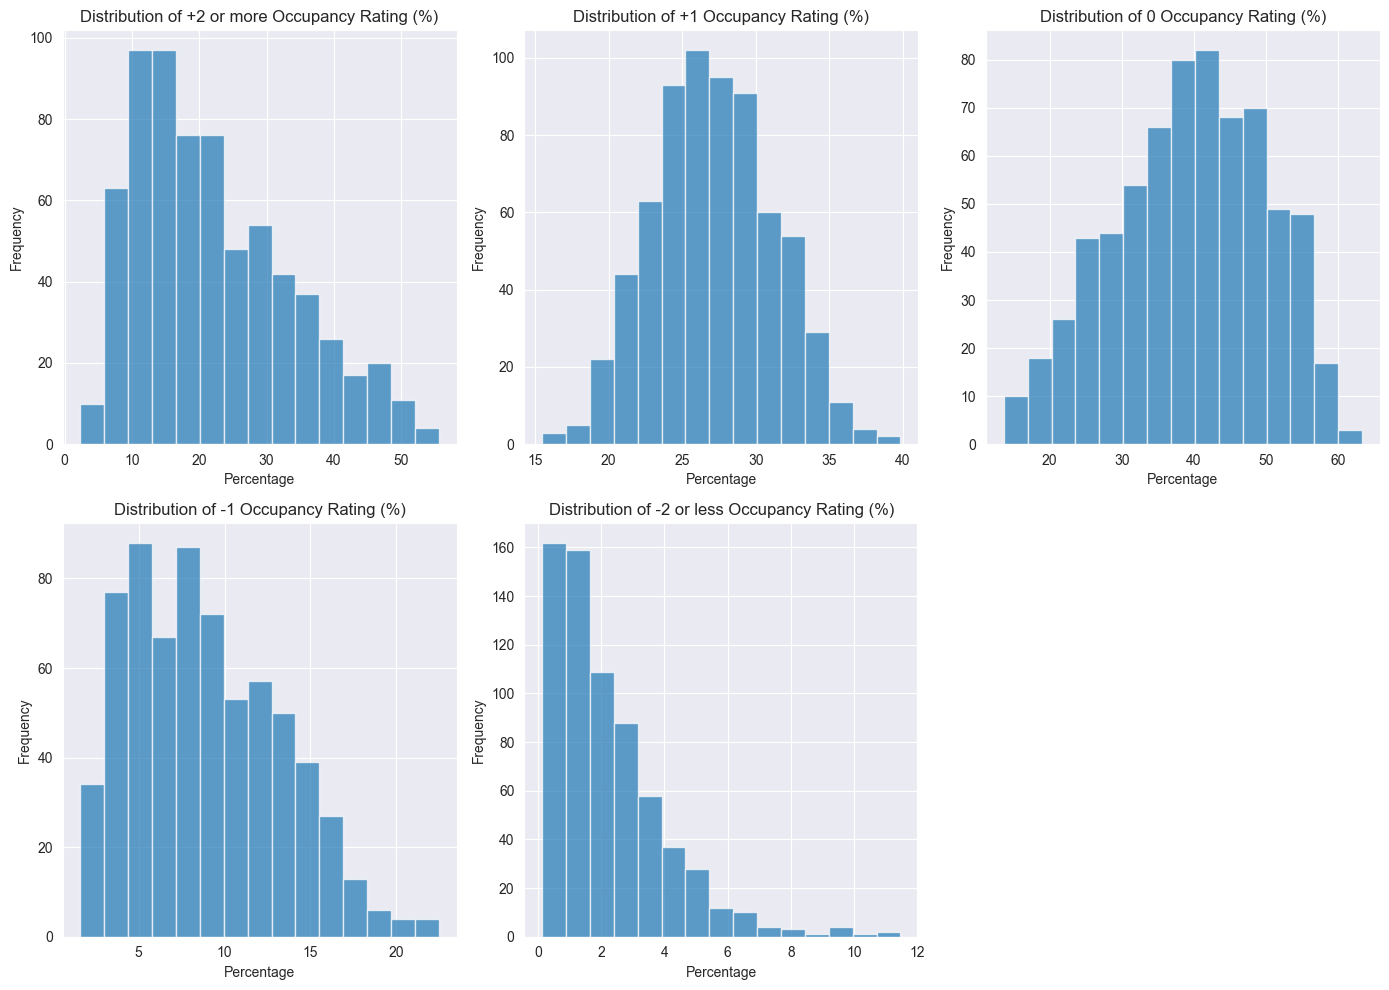

In [8]:
# Create histograms to visualize distributions
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.hist(merged_data['pct_plus2_more'], bins=15, alpha=0.7)
plt.title('Distribution of +2 or more Occupancy Rating (%)')
plt.xlabel('Percentage')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(merged_data['pct_plus1'], bins=15, alpha=0.7)
plt.title('Distribution of +1 Occupancy Rating (%)')
plt.xlabel('Percentage')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(merged_data['pct_zero'], bins=15, alpha=0.7)
plt.title('Distribution of 0 Occupancy Rating (%)')
plt.xlabel('Percentage')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.hist(merged_data['pct_minus1'], bins=15, alpha=0.7)
plt.title('Distribution of -1 Occupancy Rating (%)')
plt.xlabel('Percentage')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(merged_data['pct_minus2_less'], bins=15, alpha=0.7)
plt.title('Distribution of -2 or less Occupancy Rating (%)')
plt.xlabel('Percentage')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



## 3. Single Variable Regression Models

In [9]:

# Function to run simple linear regression and print results
def run_simple_regression(X_var, y_var, data, var_name):
    X = data[[X_var]]
    y = data[y_var]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"Regression Results for {var_name}:")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Coefficient: {model.params[1]:.4f}")
    print(f"P-value: {model.pvalues[1]:.4f}")
    print(f"Statistical significance: {'Yes' if model.pvalues[1] < 0.05 else 'No'}")
    print("\nModel Summary:")
    print(model.summary().tables[1])
    X = data[X_var]
    y = data[y_var]
    corr, pval = pearsonr(X, y)
    print(f"\nNormal linear regression: {corr}")
    print("\n" + "-"*60 + "\n")
    return model

# Run regression for each occupancy variable
models = {'pct_plus2_more': run_simple_regression('pct_plus2_more', 'burglary_pct', merged_data,
                                                  "Percentage of +2 or more Occupancy"),
          'pct_plus1': run_simple_regression('pct_plus1', 'burglary_pct', merged_data,
                                             "Percentage of +1 Occupancy"),
          'pct_zero': run_simple_regression('pct_zero', 'burglary_pct', merged_data,
                                            "Percentage of 0 Occupancy"),
          'pct_minus1': run_simple_regression('pct_minus1', 'burglary_pct', merged_data,
                                              "Percentage of -1 Occupancy"),
          'pct_minus2_less': run_simple_regression('pct_minus2_less', 'burglary_pct', merged_data,
                                                   "Percentage of -2 or less Occupancy")}


Regression Results for Percentage of +2 or more Occupancy:
R-squared: 0.1873
Coefficient: -0.0030
P-value: 0.0000
Statistical significance: Yes

Model Summary:
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2134      0.006     35.965      0.000       0.202       0.225
pct_plus2_more    -0.0030      0.000    -12.483      0.000      -0.003      -0.002

Normal linear regression: -0.43281782588536283

------------------------------------------------------------

Regression Results for Percentage of +1 Occupancy:
R-squared: 0.0660
Coefficient: -0.0049
P-value: 0.0000
Statistical significance: Yes

Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2807      0.019     14.402      0.000       0.242       0.319
pct_plus

C:\Users\gusta\AppData\Local\Temp\ipykernel_37784\1005579696.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient: {model.params[1]:.4f}")
C:\Users\gusta\AppData\Local\Temp\ipykernel_37784\1005579696.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value: {model.pvalues[1]:.4f}")
C:\Users\gusta\AppData\Local\Temp\ipykernel_37784\1005579696.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"

## 4. Multivariate Regression Model with log-ratios


Log-Ratio Regression Results:
R-squared: 0.2724

Model Summary:
                            OLS Regression Results                            
Dep. Variable:           burglary_pct   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     63.00
Date:                Sun, 11 May 2025   Prob (F-statistic):           3.08e-45
Time:                        15:17:53   Log-Likelihood:                 873.89
No. Observations:                 678   AIC:                            -1738.
Df Residuals:                     673   BIC:                            -1715.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

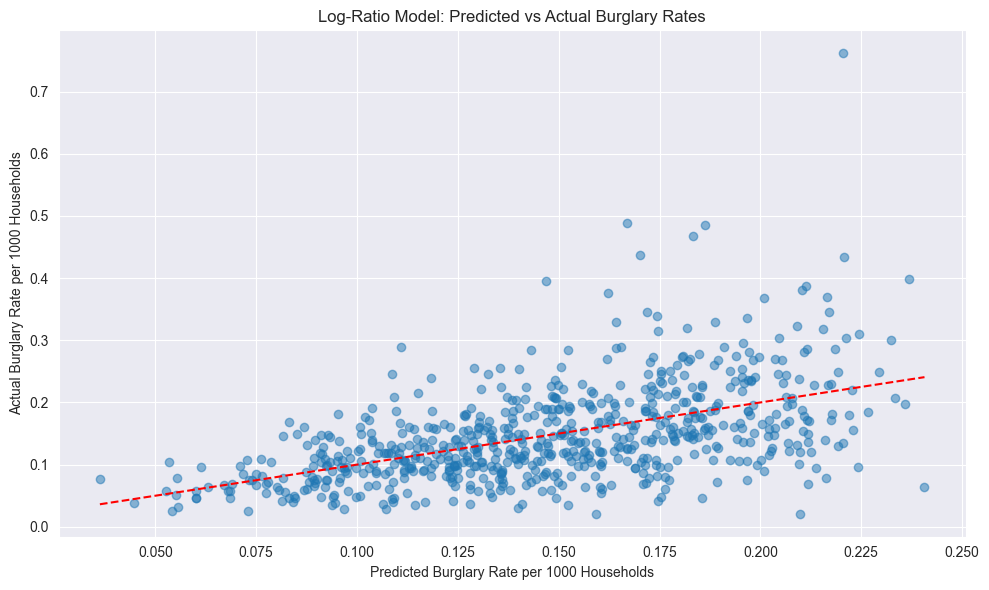

In [10]:
# Add a small constant to avoid log(0)
epsilon = 0.01
log_cols = []

for col in ['pct_plus2_more', 'pct_plus1', 'pct_zero', 'pct_minus1', 'pct_minus2_less']:
    log_col = f"log_{col}"
    merged_data[log_col] = np.log(merged_data[col] + epsilon)
    log_cols.append(log_col)

# Calculate log-ratios using pct_zero as the reference
ratio_cols = []
for col in ['pct_plus2_more', 'pct_plus1', 'pct_minus1', 'pct_minus2_less']:
    ratio_col = f"log_ratio_{col}_to_zero"
    merged_data[ratio_col] = merged_data[f"log_{col}"] - merged_data["log_pct_zero"]
    ratio_cols.append(ratio_col)

# Run regression using log-ratios
X_log_ratio = merged_data[ratio_cols]
y_log_ratio = merged_data['burglary_pct']

X_log_ratio = sm.add_constant(X_log_ratio)
log_ratio_model = sm.OLS(y_log_ratio, X_log_ratio).fit()

print("\nLog-Ratio Regression Results:")
print(f"R-squared: {log_ratio_model.rsquared:.4f}")
print("\nModel Summary:")
print(log_ratio_model.summary())

# Check for multicollinearity in the log-ratio model
print("\nVariance Inflation Factors (VIF) for Log-Ratio Model:")
vif_data_log = pd.DataFrame()
vif_data_log["Variable"] = X_log_ratio.columns
vif_data_log["VIF"] = [variance_inflation_factor(X_log_ratio.values, i) for i in range(X_log_ratio.shape[1])]
print(vif_data_log)

# Visualize the predicted vs actual values for the log-ratio model
plt.figure(figsize=(10, 6))
predictions = log_ratio_model.predict(X_log_ratio)
plt.scatter(predictions, y_log_ratio, alpha=0.5)
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], 'r--')
plt.xlabel('Predicted Burglary Rate per 1000 Households')
plt.ylabel('Actual Burglary Rate per 1000 Households')
plt.title('Log-Ratio Model: Predicted vs Actual Burglary Rates')
plt.tight_layout()
plt.show()